### Importing the neseccary libraries

In [46]:
import numpy as np
import pandas as pd
import random 
from scipy import interpolate
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression # Works 
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR # Nope
from sklearn.tree import DecisionTreeRegressor # Works best 

In [47]:
# Preparation for selecting only the feature columns
cols = []
for i in range(1, 48):
    cols.append("x" + str(i))

In [48]:
# Selecting the features
X = pd.read_csv("moon14-15.csv", usecols = cols)
# Selecting the predection output
Y = pd.read_csv("moon14-15.csv", usecols = 'y')

### Dealing with Null values

In [49]:
for x in cols:
    print(x +": ", end = "")
    print(X[x].isnull().values.any())

x1: False
x2: False
x3: False
x4: False
x5: False
x6: False
x7: False
x8: False
x9: False
x10: False
x11: False
x12: False
x13: False
x14: False
x15: False
x16: False
x17: False
x18: False
x19: False
x20: False
x21: False
x22: False
x23: False
x24: False
x25: False
x26: False
x27: False
x28: False
x29: False
x30: False
x31: False
x32: False
x33: False
x34: False
x35: False
x36: False
x37: False
x38: False
x39: False
x40: False
x41: False
x42: False
x43: False
x44: False
x45: False
x46: False
x47: False


In [50]:
print(Y.isnull().values.any())

True


In [51]:
Y = Y.fillna(0)
print(Y.isnull().values.any())

False


### Splitting the training data to Train, Test and Validation

In [52]:
X_TrainAndTest, X_validation, Y_TrainAndTest, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(X_TrainAndTest, Y_TrainAndTest, test_size = 0.5, random_state = 42)

In [53]:
# Feature subset fitness function
def getFitness(individual, X_train, X_test, y_train, y_test):
    
    # Removing feature columns that we don't use
    cols_ = [index for index in range(len(individual)) if individual[index] == 0]
    X_trainParsed = X_train.drop(X_train.columns[cols_], axis = 1)
    X_testParsed = X_test.drop(X_test.columns[cols_], axis = 1)

    #Applying ML algorithm and calculating the accuracy 
    
    # Linear Regression
    # clf = LinearRegression()
    # clf.fit(X_trainParsed, y_train)
    # predictions = clf.predict(X_testParsed)
    
    # SVR
    # svr_rbf = SVR(kernel = 'rbf', C = 1e3, gamma = 0.1)
    # svr_rbf.fit(X_trainParsed, y_train)
    # predictions = svr_rbf.predict(X_testParsed)
    
    # Decision Tree Regressor
    clf = DecisionTreeRegressor()
    clf.fit(X_trainParsed, y_train)
    predictions = clf.predict(X_testParsed)
    
    rmse = mean_squared_error(y_test, predictions)
    
    return (rmse,)

In [54]:
# Deep Global variables

# Create Individual 
creator.create("FitnessMin", base.Fitness, weights = (-1.0, ))
creator.create("Individual", list, fitness = creator.FitnessMin)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(cols))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox
toolbox.register("evaluate", getFitness, X_train = X_train, X_test = X_test, y_train = Y_train, y_test = Y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.05)
toolbox.register("select", tools.selTournament, tournsize = 3)

C:\Users\Akshath\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Akshath\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [55]:
def getHOF():
    
    numPop = 100
    numGen = 50
    pop = toolbox.population(n = numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    #Launch GA
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb = 0.5, mutpb = 0.2, ngen = numGen, stats = stats, 
                                   halloffame = hof, verbose = True)
    # Return hall of fame
    return hof

In [56]:
def getMetrics(hof):
    
    # Get list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
    
    # Gather fitness data from each percentile
    testAccuracyList = []
    validationAccuracyList = []
    individualList = []
    for individual in hof:
        testAccuracy = individual.fitness.values
        validationAccuracy = getFitness(individual, X_TrainAndTest, X_validation, Y_TrainAndTest, Y_validation)
        testAccuracyList.append(testAccuracy[0])
        validationAccuracyList.append(validationAccuracy[0])
        individualList.append(individual)
    testAccuracyList.reverse()
    validationAccuracyList.reverse()
    return testAccuracyList, validationAccuracyList, individualList, percentileList


Test accuracy with all features: 	1.14775145771
Validation accuracy with all features: 	0.709614574575

gen	nevals	avg    	std     	min     	max    
0  	100   	1.03509	0.188619	0.630146	1.48715
1  	67    	0.89843	0.169923	0.5119  	1.50399
2  	63    	0.789272	0.12291 	0.491313	1.09076
3  	67    	0.743044	0.127688	0.491269	1.15008
4  	65    	0.710438	0.143497	0.488127	1.20849
5  	62    	0.670557	0.131575	0.452609	1.1242 
6  	57    	0.67224 	0.163535	0.452609	1.21418
7  	52    	0.650623	0.159853	0.441923	1.13854
8  	67    	0.701088	0.192413	0.441923	1.30602
9  	59    	0.668764	0.159291	0.441923	1.33239
10 	67    	0.671455	0.158454	0.424752	1.219  
11 	58    	0.661086	0.161521	0.424752	1.13841
12 	53    	0.650166	0.162305	0.424752	1.17353
13 	56    	0.644176	0.173744	0.424752	1.52388
14 	60    	0.654521	0.187754	0.415071	1.40871
15 	56    	0.625115	0.166449	0.415071	1.28033
16 	64    	0.635168	0.164028	0.423703	1.18404
17 	59    	0.676309	0.222362	0.423703	1.73899
18 	52    	0.634776	0.18

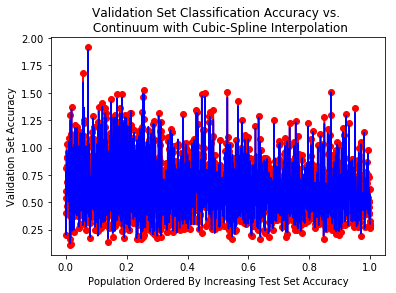

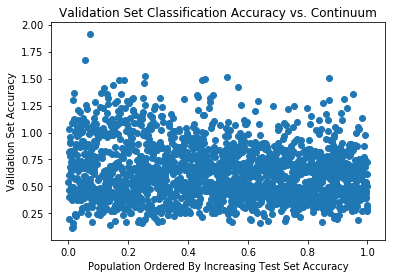

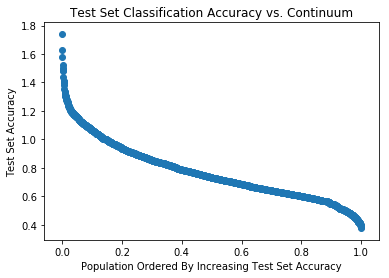

In [57]:
if __name__ == '__main__':

    '''
    First, we will apply logistic regression using all the features to acquire a baseline accuracy.
    '''
    individual = [1 for i in range(len(cols))]
    testAccuracy = getFitness(individual, X_train, X_test, Y_train, Y_test)
    validationAccuracy = getFitness(individual, X_TrainAndTest, X_validation, Y_TrainAndTest, Y_validation)
    print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
    print('Validation accuracy with all features: \t' + str(validationAccuracy[0]) + '\n')

    '''
    Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
    '''
    hof = getHOF()
    testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)

    # Get a list of subsets that performed best on validation data
    maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
    maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
    maxValSubsets = [[list(cols)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

    print('\n---Optimal Feature Subset(s)---\n')
    for index in range(len(maxValAccSubsetIndicies)):
        print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
        print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
        print('Individual: \t' + str(maxValIndividuals[index]))
        print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
        print('Feature Subset: ' + str(maxValSubsets[index]))

    '''
    Now, we plot the test and validation classification accuracy to see how these numbers change as we move from our worst feature subsets to the 
    best feature subsets found by the genetic algorithm.
    '''
    # Calculate best fit line for validation classification accuracy (non-linear)
    tck = interpolate.splrep(percentileList, validationAccuracyList, s=5.0)
    ynew = interpolate.splev(percentileList, tck)

    e = plt.figure(1)
    plt.plot(percentileList, validationAccuracyList, marker='o', color='r')
    plt.plot(percentileList, ynew, color='b')
    plt.title('Validation Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Validation Set Accuracy')
    plt.show()

    f = plt.figure(2)
    plt.scatter(percentileList, validationAccuracyList)
    plt.title('Validation Set Classification Accuracy vs. Continuum')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Validation Set Accuracy')
    plt.show()

    g = plt.figure(3)
    plt.scatter(percentileList, testAccuracyList)
    plt.title('Test Set Classification Accuracy vs. Continuum')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Test Set Accuracy')
    plt.show()



In [60]:
columns_ = ['x1', 'x2', 'x9', 'x11', 'x12', 'x13', 'x14', 'x16', 'x18', 'x21', 'x30', 'x31', 'x32', 'x34', 'x35', 'x36', 'x41', 'x47']

In [79]:
clf1 = DecisionTreeRegressor()

# Taking the necessary columns from the Training Set
X_TrainAndTest = X_TrainAndTest[columns_]
X_validation = X_validation[columns_]

clf1.fit(X_TrainAndTest, Y_TrainAndTest)
predictions = clf1.predict(X_validation)

rmse = mean_squared_error(Y_validation, predictions)

In [80]:
print(rmse)

0.373249423426
